<img src="../../Img/backdrop-wh.png" alt="Drawing" style="width: 300px;"/>  

# GPT Finetuning

* * * 

<div class="alert alert-success">  
    
### Learning Objectives 
    
* Understand GPT-2 as a large language model.
* Reviewing output from pretrained GPT-2 model using the `transformers` library.
* Understand the hyperparameters for GPT-2's output generation.
* Learn how to finetune GPT-2 on AITA data.
* Evaluate differently finetuned GPT-2 models through manual interpretation.

</div>

### Icons Used in This Notebook
🔔 **Question**: A quick question to help you understand what's going on.<br>
⚠️ **Warning:** Heads-up about tricky stuff or common mistakes.<br>

### Sections
1. [What is a Large Language Model?](#llm)
2. [What is GPT-2?](#gpt2)
3. [Finetuning GPT-2](#ft)
4. [Evaluation: Perplexity](#perp)
5. [Evaluation: Interpretation](#int)

<a id='llm'></a>
# What is a Large Language Model?

Large Language Models (LLMs) are machine learning systems trained to predict the next word in a sequence of text. They’re called “large” because they’re built using massive amounts of text data and contain billions of parameters—tunable weights that determine the model’s behavior.

LLMs learn patterns in language by analyzing word sequences, grammar, facts, and even writing styles from their training data. Rather than memorizing specific phrases, they build a statistical understanding of how language works. This allows them to generate surprisingly fluent and coherent text, answer questions, summarize content, and more.

<a id='gpt2'></a>
# What is GPT-2?

**GPT-2 (Generative Pre-trained Transformer 2)**, developed by OpenAI, is a well-known example of an LLM. It’s trained on a broad dataset from the internet and can generate human-like text on a wide variety of topics.

"GPT" Stands for Generative Pre-trained Transformer. *Generative*, because it generates text. Pre-trained, because it has been trained on a massive amount of data, and "pre" insinuates one could further train, or **finetune**, this model. A *transformer* is a specific kind of neural network. You can build different models from transformer architecture; the training goal of GPT is to take in a piece of text, and produce a prediction of what comes next in the passage.

GPT-2 is a model from 2019. It was trained on a dataset of 8 million web pages. In this notebook, we are using GPT-2 Small, the base model, which has only (!) 117 million parameters (for comparison, GPT-2 XL has 1.5 billion parameters, and GPT4 has 175 *billion*). A "parameter" is an adjustable internal value that the model learns and uses to make predictions or generate text based on its input. More parameters usually means a "smarter", more capable model.

We use this smaller model to make it possible to finetune it on a local computer (although you still need a pretty recent machine to run the code in this notebook). 

## What is fine-tuning?
Fine-tuning GPT-2 on a specific dataset, like our r/amitheasshole dataset, customizes the model's responses to reflect the themes, style, language, or idioms found within that corpus. This process tailors the model's generative capabilities, making it more likely to produce outputs that are stylistically and thematically aligned with the fine-tuning material.

The model's adaptation will be more pronounced when generating text related to or prompted by the domain we train it on. This might include specific narrative styles, dialogue structures, and  conventions unique to Am I The Asshole.

## Weight Adjustment
Fine-tuning adjusts the weights of the neural network to minimize the loss on the new data. The changes in weights help the model better predict or generate sequences that resemble the fine-tuning data.

## Importing packages

⚠️ **Warning:** I recommend running this code in a new **environment**, since the PyTorch and Transformers packages might clash with other installed packages. 

I highly recommend following the **"How to create Conda Environments & Install Dependencies"** page on bCourses if you want to know how to create environments. 

In [1]:
# Uncomment the following to install PyTorch and Transformers libraries

#%pip install pytorch
#%pip install transformers 

After importing, check which versions of the packages we have.

In [1]:
import torch
import transformers
print(torch.__version__)
print(transformers.__version__)

2.7.0
4.52.4


Let's generate some text. We will use DistilGPT2 (short for Distilled-GPT2), a model pre-trained with the supervision of the smallest version of Generative Pre-trained Transformer 2 (GPT-2). 

Our input text will be a typical title from an r/aita post. By looking at how the model completes this sentence, we get a sense of its internal logic, and whether it "understands" what an r/aita post looks like.

In [2]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Set the seed for PyTorch (controls randomness for reproducibility)
seed = 1
torch.manual_seed(seed)

# Load pretrained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('distilgpt2')

# Encode input context to get token IDs
input_text = "AITA for pretending to get fired when customers get a temper with me?"
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Generate text using the model
output = model.generate(input_ids, 
                        do_sample=True, 
                        max_length=150, 
                        repetition_penalty=1.1,
                        temperature=.5, 
                        top_k=30, 
                        top_p=0.95
                        )

# Decode the generated IDs to text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(generated_text)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


AITA for pretending to get fired when customers get a temper with me?
The BJP government has said it will not allow the firing of an employee after its election results in August. The decision is expected to be taken by next month's general elections and would have triggered protests across India, including at least 12 people who were injured during Election Day last year.


🔔 **Question**: Does this output make sense? 

### On Predicting Text

What is happening here? The model tokenizes our `input_text` into subwords (or tokens), and then maps each token onto an embedding vector (i.e., a long list of numbers), which it has learned during training. The model then uses these embeddings to predict the most-likely words to appear after our input text ends. It then draws on probability distribution to generate text, word by word.

A few things to note about the arguments we pass into `model.generate`:

- When `do_sample=True`, the model generates text by **sampling** from the probability distribution of the next token given the context. This distribution is determined by the model's predictions. Instead of simply picking the most probable next token (deterministic), the model randomly selects the next token based on this probability distribution, which can introduce variety and creativity in the generated text.
- `max_length` tells the model how many tokens its response should be.
- Parameters like `temperature`, `top_k`, and `top_p` modify this distribution to control diversity and coherence of the output:
    - `temperature`: Controls the randomness of the generated output. Higher temperature makes the output distribution more uniform, so you are likely to get more diverse generations
    - `top-p`: Samples tokens with the highest probability scores until the sum of the scores reaches the specified threshold value. 
    - `top-k`: Samples tokens with the highest probabilities until the specified number of tokens is reached.
 


### Visualizing Embeddings 

As we have seen last week, visualizing the embedding space of a model can provide valuable insights into the structure and potential biases of the learned representations. 

Let's do this for the `distilgpt2` model using principal component analysis (PCA).

In [3]:
model = GPT2LMHeadModel.from_pretrained('distilgpt2')
embeddings = model.transformer.wte.weight.detach().numpy()

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
words = ["mother", "father", "wife", "husband", "sibling", "friend", "asshole", "selfish", "dishonest", "belittles", "dismissive", "inconsiderate", "overreacts"]
word_indices = [tokenizer.encode(word)[0] for word in words]
selected_embeddings = embeddings[word_indices]

In [4]:
selected_embeddings

array([[-0.08683544, -0.0742779 ,  0.08279706, ...,  0.1882141 ,
         0.08212308, -0.00772696],
       [-0.04411615, -0.2743945 ,  0.09602286, ...,  0.1457259 ,
         0.1467388 , -0.01477893],
       [ 0.02956365, -0.10193486,  0.04898852, ..., -0.08164124,
         0.27095503, -0.17627896],
       ...,
       [ 0.09597927, -0.07860076,  0.2188769 , ...,  0.27255607,
         0.14034851, -0.02970902],
       [-0.01643876, -0.17959502,  0.17055063, ...,  0.0508506 ,
         0.04920006, -0.05104805],
       [-0.07287488, -0.13610548,  0.06346617, ...,  0.15324672,
        -0.18826947,  0.02226485]], dtype=float32)

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Using PCA
pca = PCA(n_components=2)
reduced_embeddings_pca = pca.fit_transform(selected_embeddings)

In [6]:
# Uncomment the following line to install adjustText 

#%conda install adjustText

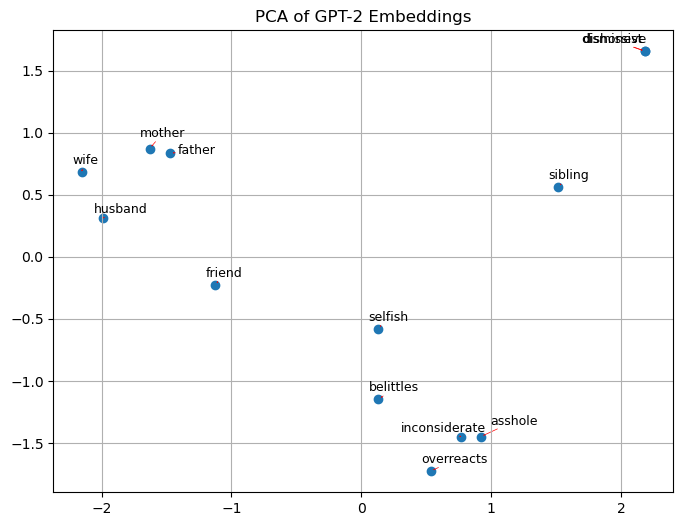

In [7]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Function to plot
def plot_embeddings(embeddings, labels, title='PCA of GPT-2 Embeddings'):
    plt.figure(figsize=(8, 6))
    texts = []
    points = plt.scatter(embeddings[:, 0], embeddings[:, 1])  # scatter plot of embeddings

    # Generate text annotations
    for i, label in enumerate(labels):
        x, y = embeddings[i]
        text = plt.text(x, y, label, ha='right', va='bottom', fontsize=9)
        texts.append(text)

    # Use adjust_text to avoid overlapping
    adjust_text(texts, x=embeddings[:, 0], y=embeddings[:, 1], arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

    plt.title(title)
    plt.grid(True)
    plt.show()

# Example usage (assuming 'reduced_embeddings_pca' and 'words' are defined)
plot_embeddings(reduced_embeddings_pca, words, title='PCA of GPT-2 Embeddings')


<a id="ft"></a>

# Finetuning GPT-2 - OPTIONAL

### ⚠️ Warning
Even though we are only training a small model, the following blocks of code operation will take long on a consumer-grade PC (for reference: around 4 hours on an Apple M2 Pro with 16GB memory). I have run this code and saved the model, so you don't have to run it yourself. Please move on to "Getting the Model From Google Drive". 

If you do choose to run the model yourself, you may want to run this notebook in Google Colab using a GPU. See Modules in bCourses for the link.


## Tokenizing our Data

Time to start the finetuning process. We first load in our r/aita dataset and initialize a tokenizer.

The tokenizer performs several critical tasks to convert raw text into a format that the GPT-2 model can understand:

- Splitting Text into Tokens: The tokenizer breaks down input text into tokens. For GPT-2, these tokens are usually subwords or characters, allowing the model to handle a wide range of words and vocabularies efficiently.
- Converting Tokens to IDs: Each token is mapped to a unique integer ID based on the GPT-2 vocabulary. This conversion is necessary because neural networks operate on numerical data, not raw text.
- Adding Special Tokens: GPT-2 requires certain special tokens for its operation (e.g., end-of-text token). The tokenizer takes care of adding these tokens where appropriate.
- Padding & Truncation: To process batches of data efficiently, all input sequences must be of the same length. The tokenizer can pad shorter sequences with a special padding token or truncate longer ones to a maximum length.
- Creating Attention Masks: The tokenizer generates attention masks to differentiate real tokens from padding tokens. This helps the model pay attention to relevant tokens and ignore padded areas.

In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv('../../data/aita_pp.csv')

In [9]:
texts = df['selftext'].tolist()

In [10]:
texts

['My girlfriend recently went to the beach with a few of her friends.  She has this tiny bikini bottom that is basically a thong that I HATE when she wears in public.  Well she wore it.  Not only did she wear it, she posed in the bathroom mirror of her hotel room to take a side profile picture so you could see her ass sticking out in it and posted it to her Snapchat story.   Worth mentioning I am not friends with her on Snapchat for reasons similar to this (sick of getting in fights when she says she\'s going out for \'girls\' night then posts videos of her sitting at a table with like 5 dudes that always got invited by one of the other girls which was completely unknown to her until she arrived - most of these guys she then adds on Snapchat afterwards).  She didn\'t even save it and send it to me.  I saw it when she was showing me pics from her beach trip and she had screenshot that particular snap and left it in her camera roll.  Whether the ass part was intentional or not I will nev

## Commence Tokenization

We will tokenize the entire texts with truncation and padding to a fixed maximum length. This method is straightforward and treats each text as an individual sequence for the model to learn from. The main characteristics include:

- `truncation`: Texts longer than `max_length=512` are cut off, potentially losing important information at the end.
- `padding`: Texts shorter than `max_length=512` are padded to ensure uniform sequence length, usually with the pad_token. This is not relevant to us as all texts we are feeding into the model are much longer than 512 tokens.

During fine-tuning, the prediction task involves predicting the next token in the sequence based on the preceding tokens. So, for each input sequence (i.e., for each Irish drama text) consisting of its first 512 tokens, the model  predicts the next token for each token position within that sequence. The model predicts tokens from the second to the 512th position within each sequence. 

In [11]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments

# Initialize tokenizer with padding token set
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
tokenizer.pad_token = tokenizer.eos_token

# Tokenize texts
encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

In [12]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    
    def __len__(self):
        return len(self.encodings.input_ids)
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # For language modeling, the labels are the input_ids shifted by one
        item["labels"] = item["input_ids"].clone()
        return item

# Initialize the dataset
train_dataset = TextDataset(encodings)

## Commence Finetuning

In the following cell, we initialize the fine-tuning process using Hugging Face's `Trainer` class.

The first parameter, `model`, is the pre-trained distilGPT-2 model that we intend to fine-tune. It has been previously loaded and is now set to be further trained on our specific dataset to adjust its weights based on the new data, enhancing its ability to generate or understand text similar to your training corpus.

`TrainingArguments` further specifies various configuration settings for the training process:
- `output_dir`: The directory where the training outputs (like the fine-tuned model checkpoints) will be saved.
- `num_train_epochs`: The number of times the training process should iterate over the entire dataset. Here, it's set to 3, meaning the model will see the dataset three times.
- `per_device_train_batch_size`: The number of training examples processed per device (e.g., GPU) per training step. A batch size of 4 is specified, balancing the computational load and memory usage.
- `logging_dir`: Directory where training logs will be saved, enabling monitoring of the training process through metrics like loss over time.

Finally, `trainer.train()` starts the training process based on the specified model, training arguments, and dataset. The Trainer handles various training aspects, including feeding the input data to the model, performing backpropagation to adjust the model's weights, saving checkpoints, and logging training progress.

⚠️ **Warning:** Even though we are using a small model, the following operation will take *long* on a consumer-grade PC (for reference: around 4 hours on an Apple M2 Pro with 16GB memory).
I have run this code and saved the model, so you don't have to run it yourself. If you choose to do so, be patient!

In [ ]:
# Initialize the model
model = GPT2LMHeadModel.from_pretrained('distilgpt2')

# Define training arguments
training_args = TrainingArguments(
    output_dir='../../results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    logging_dir='../../logs'
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

# Start training
trainer.train()

If you did run the previous code, make sure to save the model and finetuned tokenizer:

In [ ]:
model_save_path = '../../models/finetuned_model'
tokenizer_save_path = '../../models/finetuned_tokenizer'

# Save the model
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)


## Getting the Model From Google Drive

To save us time, I saved the model we created on Google Drive. A link to the folder you need to download is in bCourses under Modules (look for "Finetuned GPT2 Model on Google Drive"). 

Download **the entire "models" folder**

<img src="../../img/download-models.png" alt="Downloading the entire models folder from Google Drive" width="500"/>

Next, extract/unzip this folder, and put in the top level of your local "DIGHUM160-main" repo. 

The result should be that you have the "models" folder inside your "DIGHUM160-main" folder, like so:

<img src="../../img/ex.png" alt="Making sure 'models' and 'tokenizer' folders are present in DIGHUM160 folder" width="500"/>


<a id="int"></a>
# Interpreting Model Output

Let's have a look at the ways DistilGPT2's behavior has been altered due to the finetuning on r/aita.

In [26]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Set the seed for PyTorch (controls randomness for reproducibility)
seed = 1
torch.manual_seed(seed)

def generate_text(model, prompt, do_sample=True, max_length=50, temperature=1, top_k=50, top_p=0.95, repetition_penalty=1.1):
    """
    Generates text based on a given prompt using the specified model.
    
    Parameters:
    - model: The fine-tuned model to use for text generation.
    - prompt: The initial text to start generating from.
    - max_length: Maximum length of the generated text.
    - temperature: Sampling temperature for generating text.
    - top_k: The number of highest probability vocabulary tokens to keep for top-k filtering.
    - top_p: Nucleus sampling's cumulative probability cutoff to keep for top-p filtering.
    
    Returns:
    - generated_text: The generated text as a string.
    """
    # Encode the prompt text to tensor
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    
    # Generate a sequence of tokens following the prompt
    output_ids = model.generate(input_ids, max_length=max_length, 
                                temperature=temperature, 
                                do_sample=do_sample, 
                                top_k=top_k, 
                                top_p=top_p, 
                                repetition_penalty=repetition_penalty, 
                                pad_token_id=tokenizer.eos_token_id)
    
    # Decode the generated tokens to a string
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    return generated_text

# Load the fine-tuned model
ft_model = GPT2LMHeadModel.from_pretrained('../../models/finetuned_model')

# Load the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('../../models/finetuned_tokenizer')

# Prompt to generate text from - play around with this!
prompt = "AITA for pretending to get fired when customers get a temper with me?"

# Generate texts
generated_text = generate_text(ft_model, prompt, max_length=150)
print("Generated text from finetuned model:", generated_text, '\n')


Generated text from finetuned model: AITA for pretending to get fired when customers get a temper with me?
I(20F) am in college and I was at my girlfriend’s house earlier today so the heat won't go away. She tells me she is going to try and deal with it because we are both 20-24, as well as her boyfriend of around two years (my ex married 3 months before his wife left us). The reason why he has such high drama can be explained either by telling him that whatever happened during our relationship or simply being blunt about what you would think were your reasons then giving him some money will just stop working out - even if something like this happens after work but not having any control over myself isn 



## Visualizing the Finetuned Model

In [20]:
model = GPT2LMHeadModel.from_pretrained('../../models/finetuned_model')
embeddings = model.transformer.wte.weight.detach().numpy()

tokenizer = GPT2Tokenizer.from_pretrained('../../models/finetuned_tokenizer')
words = ["mother", "father", "wife", "husband", "sibling", "friend", "asshole", "selfish", "dishonest", "belittles", "dismissive", "inconsiderate", "overreacts"]
word_indices = [tokenizer.encode(word)[0] for word in words]
selected_embeddings = embeddings[word_indices]

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Using PCA
pca = PCA(n_components=2)
reduced_embeddings_pca = pca.fit_transform(selected_embeddings)

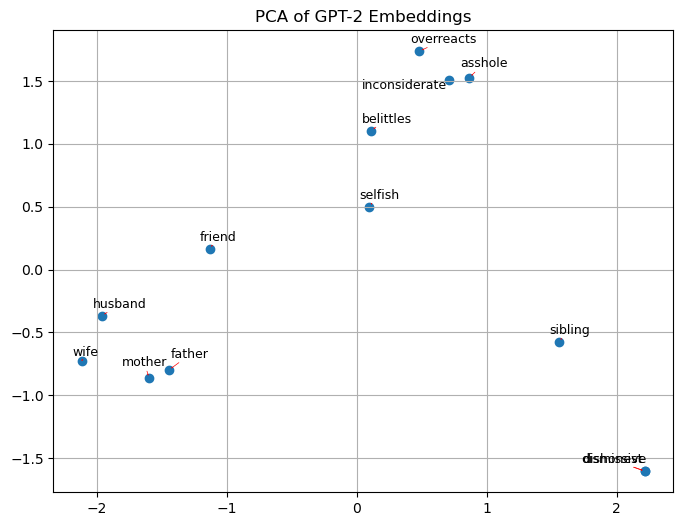

In [24]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Function to plot
def plot_embeddings(embeddings, labels, title='PCA of GPT-2 Embeddings'):
    plt.figure(figsize=(8, 6))
    texts = []
    points = plt.scatter(embeddings[:, 0], embeddings[:, 1])  # scatter plot of embeddings

    # Generate text annotations
    for i, label in enumerate(labels):
        x, y = embeddings[i]
        text = plt.text(x, y, label, ha='right', va='bottom', fontsize=9)
        texts.append(text)

    # Use adjust_text to avoid overlapping
    adjust_text(texts, x=embeddings[:, 0], y=embeddings[:, 1], arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

    plt.title(title)
    plt.grid(True)
    plt.show()

# Example usage (assuming 'reduced_embeddings_pca' and 'words' are defined)
plot_embeddings(reduced_embeddings_pca, words, title='PCA of GPT-2 Embeddings')


Note how some embeddings, like "selfish", have shifted due to the finetuning.

# Create Posts Using Finetuned Model

What can we do with this finetuned model? Well, for one, we could generate Am I The Asshole posts!

We will ask the model to generate text based on the title of the original post. We will also ask it to create a post that is the same length as the original post.

In [14]:
import pandas as pd
import random
from transformers import GPT2Tokenizer, GPT2LMHeadModel, pipeline

# Load your data
df = pd.read_csv('../../data/aita_pp.csv')

# Randomly select 10 entries
sample_df = df.sample(n=10, random_state=1)  # Use a fixed seed for reproducibility, if needed

original_texts = sample_df['selftext'].tolist()  # Adjust column name if different
titles = sample_df['title'].tolist()

# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('../../models/finetuned_tokenizer')
model = GPT2LMHeadModel.from_pretrained('../../models/finetuned_model')

# Initialize the generation pipeline
generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=-1)  # CPU usage

# Prepare to generate texts
generated_texts = []
for title, original_text in zip(titles, original_texts):
    # Calculate the length of the original post in tokens
    target_length = len(tokenizer.encode(original_text))

    # Generate a new post of the same length starting from the title
    # Ensure to set max_length to the length of the original post
    prompt = title
    generated = generator(prompt, max_length=target_length, num_return_sequences=1)[0]['generated_text']
    generated_texts.append(generated)

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=731) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=477) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=285) seem to have been set. `max_new_tokens` will take pre

Let's save the original and generated posts in a new DataFrame so we can easily compare them.

In [15]:
df = pd.DataFrame({
    'original_text': original_texts,
    'generated_text': generated_texts,
    'title': titles  # Assuming you have a list of titles
})

In [16]:
df

,original_text,generated_text,title
0,"Just recently, our local Walmart and Target ha...",AITA for refusing to show my receipt when leav...,AITA for refusing to show my receipt when leav...
1,Please excuse any mistakes. I’m on mobile. \n\...,AITA for not wanting my fiancé’s parents to mo...,AITA for not wanting my fiancé’s parents to mo...
2,My brother was recently diagnosed with late st...,AITA for not wanting to pay for brother's life...,AITA for not wanting to pay for brother's life...
3,I am a woman in my 20s who has very short hair...,AITA for shaming a barber online that refused ...,AITA for shaming a barber online that refused ...
4,my wife (27f) and me (36m) were having thanksg...,AITA for not defending my wife at the dinner t...,AITA for not defending my wife at the dinner t...
5,28f/29m been together for like 4 years I think...,AITA for telling my BF that if he doesnt go to...,AITA for telling my BF that if he doesnt go to...
6,So about 5 months ago I (29F) got a new place ...,AITA for refusing to cook dinner if my roommat...,AITA for refusing to cook dinner if my roommat...
7,"I am an atheist, and my mom has known this sin...",AITA for walking out on my own birthday party ...,AITA for walking out on my own birthday party ...
8,Throwaway\n\nTL;DR: Got the most basic pulled ...,AITA for bringing home a basic burrito for my ...,AITA for bringing home a basic burrito for my ...
9,"I've started biking to my job, to the gym, to ...",AITA for screaming really loud when drivers co...,AITA for screaming really loud when drivers co...


## Back to TF-IDF

We can use the TF-IDF algorithm to check the similarity between original texts and the ones we generated!

In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Combine original and generated texts into one list for TF-IDF analysis
texts = df['original_text'].tolist() + df['generated_text'].tolist()

# Initialize a TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the data
tfidf_matrix = vectorizer.fit_transform(texts)

# Calculate cosine similarity between original and generated texts
# Assuming the first half are originals and the second half are generated
similarity_matrix = cosine_similarity(tfidf_matrix[:len(df)], tfidf_matrix[len(df):])

# Display similarity results
for i, similarity in enumerate(similarity_matrix.diagonal()):
    print(f"Text {i+1} Similarity between original and generated: {similarity:.4f}")


Text 1 Similarity between original and generated: 0.3182
Text 2 Similarity between original and generated: 0.2118
Text 3 Similarity between original and generated: 0.1946
Text 4 Similarity between original and generated: 0.3724
Text 5 Similarity between original and generated: 0.3840
Text 6 Similarity between original and generated: 0.3580
Text 7 Similarity between original and generated: 0.4418
Text 8 Similarity between original and generated: 0.4443
Text 9 Similarity between original and generated: 0.3679
Text 10 Similarity between original and generated: 0.3635


These results, with values primarily between 0.3 and 0.5, suggest that the generated texts share some vocabulary and thematic elements with the original texts but also diverge in significant ways.

## Back to Word Embeddings

Finally, let's project the reduced embeddings for both the original and our generated posts in 2D space.

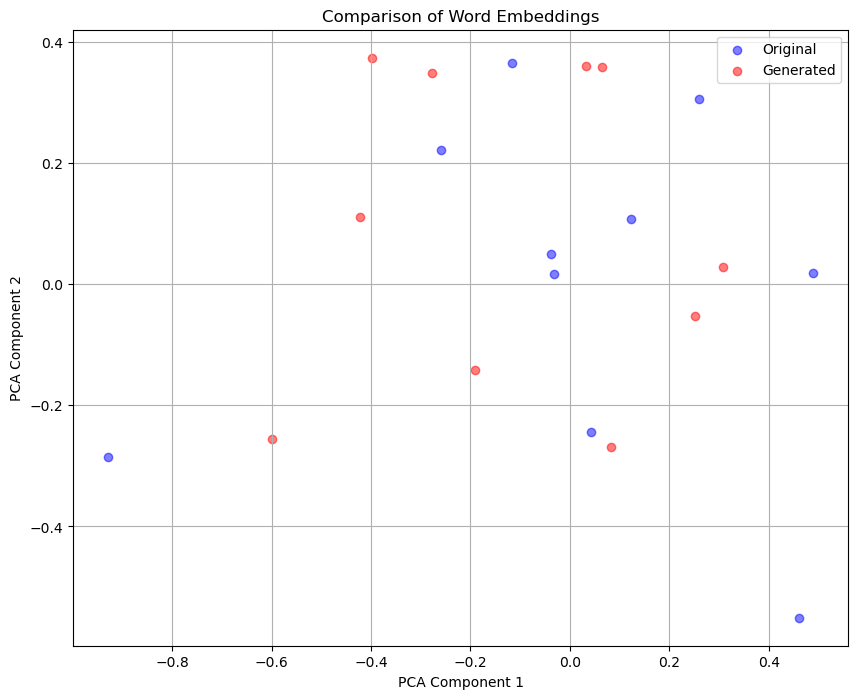

In [18]:
import spacy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the medium model with word vectors
nlp = spacy.load("en_core_web_sm")

# Sample data (assuming df is already loaded)
original_texts = df['original_text'].tolist()[:10]  # Limiting for simplicity
generated_texts = df['generated_text'].tolist()[:10]

# Function to compute average embeddings for a text
def get_average_embedding(text, nlp_model):
    doc = nlp_model(text)
    vectors = [word.vector for word in doc if not word.is_stop and word.has_vector]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros((nlp_model.vocab.vectors_length,))

# Compute average embeddings for each set of texts
original_embeddings = np.array([get_average_embedding(text, nlp) for text in original_texts])
generated_embeddings = np.array([get_average_embedding(text, nlp) for text in generated_texts])

# Perform PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
original_pca = pca.fit_transform(original_embeddings)
generated_pca = pca.transform(generated_embeddings)

# Plotting the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(original_pca[:, 0], original_pca[:, 1], color='blue', label='Original', alpha=0.5)
plt.scatter(generated_pca[:, 0], generated_pca[:, 1], color='red', label='Generated', alpha=0.5)
plt.title('Comparison of Word Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


Let's compare original posts to the ones we created with GPT-2. Here we are selecting an index from our new DataFrame and printing the text for both the original and our generated text.

**🔔 Question:** What do you make of this specific generated post? Can you tell why the model seems to have created the output that it did?

## Back to Close Reading

Finally, let's read these generated r/amitheasshole posts. Change the `index` number to see different real vs. generated posts.

In [19]:
index = 2
print(f"Title: {df.loc[index]['title']}")
print("\n")
print(f"Original Text: {df.loc[index, 'original_text']}")
print("\n")
print(f"Generated Text: {df.loc[index, 'generated_text']}")

Title: AITA for not wanting to pay for brother's life-saving surgery?


Original Text: My brother was recently diagnosed with late stage colon cancer and has been in hospital multiple times to get assessments and diagnostic testing. The definitive treatment is a surgery and lengthy hospital stay which costs about $25k out-of-pocket after insurance deductions, and quoted at 70% cure rate. He and my SIL are unable to afford this as they have combined debts of $40k including student loans and not eligible to take more credit. They can at most put together $5000 in time to have the surgery soon enough that it's still effective.

They came to me asking for a loan of $20k. This is my brother here, and they have a 4-year-old daughter and I wouldn't wish for anyone to see their dad die. But $20k is not something we can readily hand out. Debt can destroy lives, and if my wife and I have a mortgage to pay off. If we are out $20k (which will probably get turned into a gift because that's just how

# 💭 Reflection: Defamilarized posts

Ask yourself the following questions:
- What did the model "learn" about the subreddit's linguistic patterns? What phrases, structures, or rhetorical moves show up consistently? What does this tell us about how r/AmITheAsshole functions as a discourse community?
- Pinpoint some moments where the generated text feels "almost right but wrong." What makes these moments jarring? Is it factual inconsistencies, emotional register mismatches, or something else?


<div class="alert alert-success">

## ❗ Key Points

* The GPT model is trained to take in a piece of text, and produce a prediction of what comes next in the passage.
* Fine-tuning GPT-2 on a specific dataset, like our r/amitheasshole dataset, customizes the model's responses to reflect the themes, style, language, or idioms found within that corpus.
* We can evaluate a fine-tuned model with different metrics, and through manual interpretation. 
    
</div>